# 1. Data and module import

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [99]:
df = pd.read_csv('../timeseries-forecasting/salesdata.csv', index_col='OrderDate', parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1127 entries, 2019-01-01 to 2022-01-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   QtyOrdered  1127 non-null   int64
dtypes: int64(1)
memory usage: 17.6 KB


In [100]:
# Add periodicity to DateTime index for ARIMA to ingest

df.index = pd.DatetimeIndex(df.index.values,
                               freq='infer')

# 2. EDA (Exploratory Data Analysis)

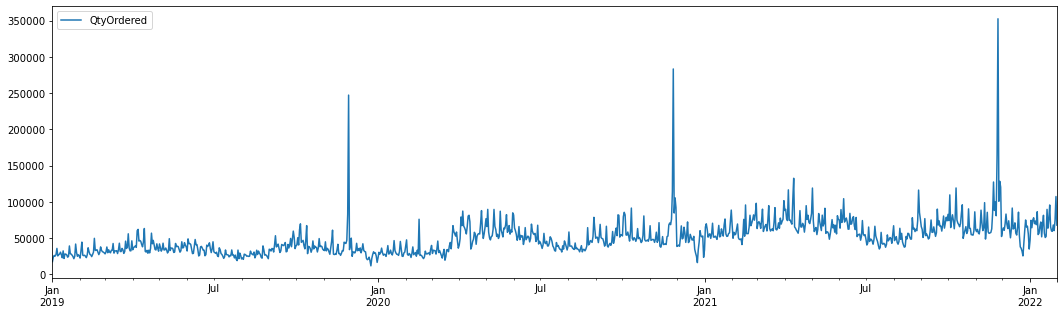

In [101]:
df.plot(figsize=(18,5));

### Check stationarity of time series using Dickey-Fuller test that assumes data is non-stationary.
- Data needs to be stationary for ARIMA model to work
- With p-value <= 0.05 we can reject null hypothesis (data is non-stationary) and accept it is stationary

In [102]:
from statsmodels.tsa.stattools import adfuller

results = adfuller(df)
print(f'p-value: {results[1]}')


p-value: 0.04637858009536599


p-value > 0.05 that means data is non-stationary and we need to transform it into stationary data using differencing method. Here, however, we have a very slight margin of error. Let's keep that in mind by comparing **df** - orginal dataset and **df_stationary** - transformed stationary data in later modeling

In [103]:
df_stationary = df.diff().dropna()

In [104]:
results = adfuller(df_stationary)
print(f'p-value: {results[1]}')

p-value: 2.012422395044514e-19


## That's about 0.00000000000000000020, which means p-value < 0.05. Data is stationary

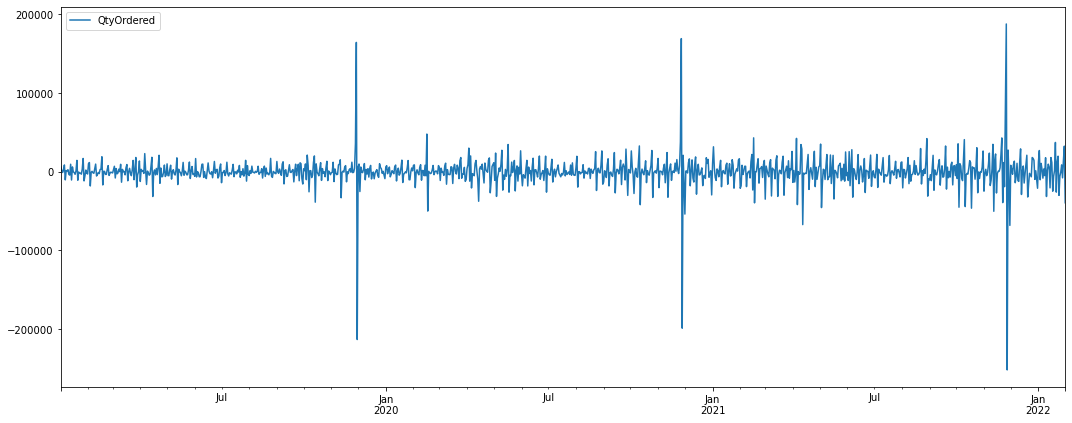

In [105]:
df_stationary.plot(figsize=(18,7));

There is also <b>ndiffs</b> function in pmdarima.arima.utils module that will help us identify the order of differencing - how many times should we difference data set in order to achieve stationarity

In [106]:
from pmdarima.arima.utils import ndiffs

print('# of differencing: ' + str(ndiffs(df.QtyOrdered, test='adf')))

# of differencing: 0


<b>ndiffs</b> also confirms that data is stationary, however, I will be using the results from ADFuller test from **statsmodel**

# 3. Finding right ***p, q, d*** terms for the ARIMA model

 ***p*** - order of Auto Regressive (AR) terms. Number of lags to be used for prediction
 
 We can use Partial Autocorrelation (correlation between time series and its lags) plot to find sufficient number of lags or AR terms 

C:\Users\208896\.conda\envs\timeseries-forecasting\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


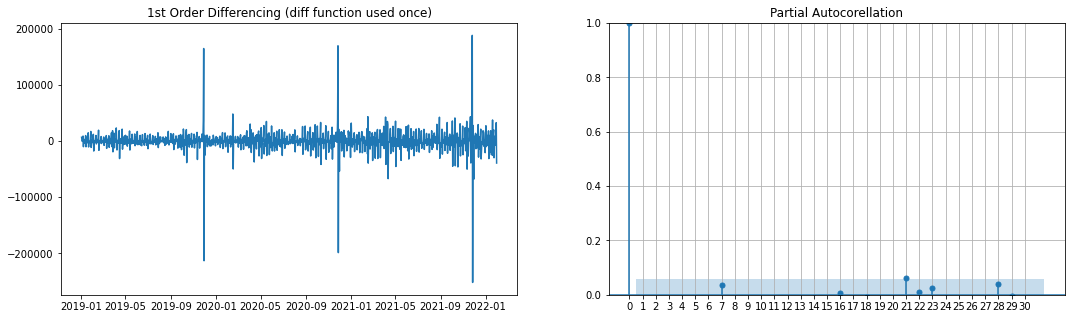

In [107]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.plot(df_stationary)
ax1.set_title('1st Order Differencing (diff function used once)')
plot_pacf(df_stationary, ax=ax2)
ax2.set_title('Partial Autocorellation')
ax2.grid(True)
ax2.set_xticks(range(0,31))
ax2.set_ylim(0, 1); # I'm only focusing on positive correlation

We can see that lag 7 or lag 21 could be sufficient as a ***p*** term as it's above the significance line

<br>

 ***q*** - order of Moving Average (MA) terms. Number of lagged forecast errors to be used for prediction
 
Here we use Autocorrelation plot, instead of Partial Autocorrelation plot to find the adequate MA terms

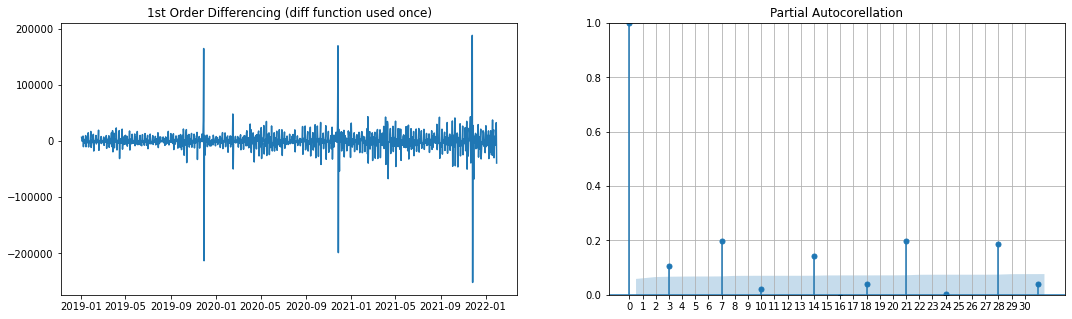

In [108]:
from statsmodels.graphics.tsaplots import plot_acf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.plot(df_stationary)
ax1.set_title('1st Order Differencing (diff function used once)')
plot_acf(df_stationary, ax=ax2)
ax2.set_title('Partial Autocorellation')
ax2.grid(True)
ax2.set_xticks(range(0,31))
ax2.set_ylim(0, 1); # I'm only focusing on positive correlation

We can see that lag 3 or lag 7 could be sufficient as a ***q*** term as it's above the significance line

# 4. Fitting the ARIMA model

In [109]:
from statsmodels.tsa.arima.model import ARIMA

train = df.loc['2019-01-01':'2022-01-22']
test = df.loc['2022-01-23':]

print(len(train))
print(len(test))

1118
9


In [110]:
model = ARIMA(train, order=(21,1,7)) # p,d,q
result = model.fit()

result.summary()

C:\Users\208896\.conda\envs\timeseries-forecasting\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             QtyOrdered   No. Observations:                 1118
Model:                ARIMA(21, 1, 7)   Log Likelihood              -12356.767
Date:                Fri, 11 Feb 2022   AIC                          24771.535
Time:                        13:52:39   BIC                          24917.069
Sample:                    01-01-2019   HQIC                         24826.550
                         - 01-22-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5519      0.039    -14.083      0.000      -0.629      -0.475
ar.L2         -0.4923      0.045    -10.867      0.000      -0.581      -0.403
ar.L3         -0.3104      0.043     -7.237      0.000      -0.394      -0.226
ar.L4         -0.3352      0.044     -7.598      0.000      -0.422      -0.249
ar.L5         -0.2948      0.042     -7.027      0.000      -0.377      -0.213
ar.L6         -0.2478      0.045     -5.496      0.000      -0.336      -0.159
ar.L7          0.7881      0.049     16.066      0.000       0.692       0.884
ar.L8          0.3427      0.072      4.769      0.000       0.202       0.484
ar.L9          0.3055      0.069      4.431      0.000       0.170       0.441
ar.L10         0.1350      0.067      2.006      0.045       0.003       0.267
ar.L11         0.1885      0.071      2.652      0.008       0.049       0.328
ar.L12         0.1527      0.075      2.042      0.041       0.006       0.299
ar.L13         0.1440      0.070      2.061      0.039       0.007       0.281
ar.L14         0.0874      0.079      1.105      0.269      -0.068       0.242
ar.L15         0.1859      0.065      2.854      0.004       0.058       0.314
ar.L16         0.1639      0.066      2.493      0.013       0.035       0.293
ar.L17         0.1498      0.067      2.252      0.024       0.019       0.280
ar.L18         0.1225      0.064      1.909      0.056      -0.003       0.248
ar.L19         0.1200      0.054      2.227      0.026       0.014       0.226
ar.L20         0.0832      0.039      2.123      0.034       0.006       0.160
ar.L21         0.0952      0.036      2.619      0.009       0.024       0.167
ma.L1          0.0016      0.043      0.038      0.970      -0.082       0.086
ma.L2         -0.0176      0.040     -0.443      0.658      -0.095       0.060
ma.L3          0.0086      0.041      0.212      0.832      -0.071       0.088
ma.L4         -0.0064      0.048     -0.133      0.894      -0.101       0.088
ma.L5         -0.0058      0.035     -0.165      0.869      -0.075       0.064
ma.L6         -0.0271      0.040     -0.681      0.496      -0.105       0.051
ma.L7         -0.9520      0.037    -25.996      0.000      -1.024      -0.880
sigma2      2.595e+08   1.07e-09   2.42e+17      0.000     2.6e+08     2.6e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):            494366.14
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.92   Skew:                             6.72
Prob(H) (two-sided):                  0.00   Kurtosis:                       105.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.22e+32. Standard errors may be unsta

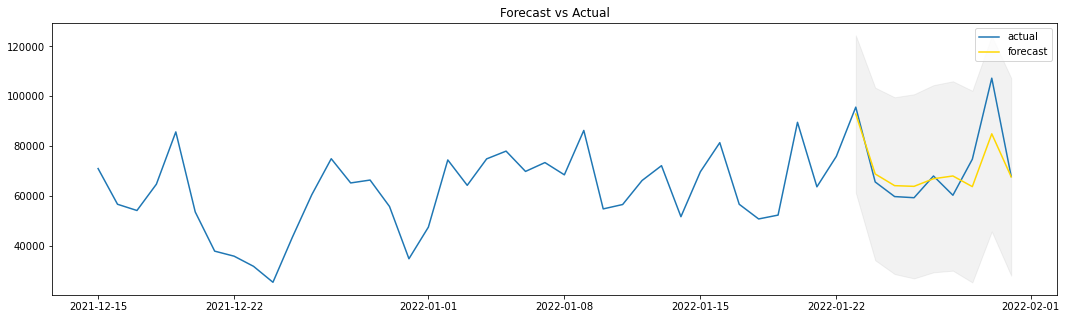

In [130]:
# Provide forecast for n days

step = 9

forecast = result.get_forecast(step)

# Confidence intervals
conf_int = forecast.conf_int()
lower_cf = conf_int.iloc[:,0]
upper_cf = conf_int.iloc[:,1]

# Forecast Series

forecast = result.get_forecast(step).predicted_mean

plt.figure(figsize=(18,5))
plt.plot(df.loc['2021-12-15':], label='actual')
plt.plot(forecast, label='forecast', c='gold')
plt.fill_between(forecast.index, lower_cf, upper_cf, color='grey', alpha=0.1)
plt.title('Forecast vs Actual')
plt.legend();

In [132]:
# Calculate MAE (mean average error)

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test, forecast)
mae


6362.357284800218

Our model is wrong by more than 6k units on average